In [1]:
%load_ext autoreload
%autoreload 2

import os, sys, shutil, bz2, copy
from pathlib import Path
import pandas as pd
pd.set_option('display.max_columns', 50)
import numpy as np
from scipy.stats import norm
from natsort import natsorted

### Plotting imports ###
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import matplotlib.colors as mcolors
import matplotlib as mpl
import matplotlib.ticker as ticker
import matplotlib.gridspec as gridspec
palette = list(mcolors.TABLEAU_COLORS.keys())
sns.set_context("notebook")
sns.set_theme(style="ticks", palette="muted")
%matplotlib inline

In [2]:
# Navigate back to NBdir in case of re-running a code block:
if not 'NBdir' in globals():
    NBdir = os.getcwd()
print('Notebook is in: {}'.format(NBdir))
os.chdir(NBdir)  # If you changed the current working dir, this will take you back to the notebook dir.

# Define the path to the repo folder.
# Change if necessary.
homedir = '/'.join(NBdir.split('/')[0:-2])
print('Repo is in: {}'.format(homedir))
sys.path.insert(1, homedir)
from src.stats_collection import STATS_collection
from src.plotting import TRNA_plot

# These are default folder names for data and raw fastq files
# relative to the folder in which this notebook is in:
data_dir = 'data'
stats_dir = 'stats_collection'
plotting_dir = 'plotting'

Notebook is in: /Users/krdav/Google Drive/MCB/Sullivan_lab/tRNA-charge-seq/projects/tRNAseq_first-gen
Repo is in: /Users/krdav/Google Drive/MCB/Sullivan_lab/tRNA-charge-seq


In [3]:
# Read the data:
sample_list_fnam = 'sample_list.xlsx'
sample_df = pd.read_excel('{}/{}'.format(NBdir, sample_list_fnam))

# Make a dictionary with paths used for data processing:
dir_dict = dict(NBdir = NBdir,
                data_dir = data_dir,
                stats_dir = stats_dir,
                plotting_dir = plotting_dir)

# Get charge dataframe for aggregated stats:
plot_obj = TRNA_plot(dir_dict, sample_df=sample_df, \
                     stats_fnam='data/stats_collection/ALL_stats_aggregate.csv', \
                     overwrite_dir=False)
tr_df = plot_obj.charge_df.merge(sample_df.loc[:, ['sample_name_unique', 'plot_group', 'hue_name', 'hue_value', 'hue_order']], on='sample_name_unique')
# tr_df['polymerase'] = [h.split('_')[0] for h in tr_df['hue_value']]
# tr_df['source'] = [h.split('_')[1] for h in tr_df['hue_value']]

# Select on inclusion list:
incl_list = ['2U1', '2U2', '4U1', '4U2', '8U1', '8U2', 'A-1', 'A-1+2',
'A-2', 'BAR1', 'BAR2', 'BAV1', 'BAV2', 'BVR1',
'BVR2', 'BVS1', 'BVS2', 'HAS1', 'HAS2', 'HAV1', 'HAV2', 'HCS1', 'HCS2',
'HCV1', 'HCV2', 'HR20S1', 'HR20S2', 'HR20V1', 'HR20V2',
'HR30P1', 'HR30P2', 'HR30S1', 'HR30S2', 'HR30V1', 'HR30V2',
'HR40P1', 'HR40P2', 'HR40S1', 'HR40S2', 'HR40V1', 'HR40V2',
'HR80P1', 'HR80P2', 'HR80S1', 'HR80S2', 'HR80V2', 'HVP1', 'HVP2',
'HVS1', 'HVS2', 'HVV1', 'HVV2', 'L-1', 'L-1+2', 'L-2',
'Rich-1', 'Rich-1+2', 'Rich-2', 'U-1', 'U-1+2', 'U-2']
mask = tr_df['sample_name_unique'].isin(incl_list)
tr_df = tr_df[mask].copy()

# Required a minimum UMI count of 1000 to keep:
min_count = 1000
tann2snu = dict()
for snu, tann, cnt in zip(tr_df['sample_name_unique'], \
                          tr_df['tRNA_annotation'], \
                          tr_df['UMIcount']):
    if cnt <= min_count:
        continue

    if tann in tann2snu:
        tann2snu[tann].add(snu)
    else:
        tann2snu[tann] = set()
        tann2snu[tann].add(snu)

# Filter tRNA annotation based on
# all samples having above the minimum count:
all_snu = set(tr_df['sample_name_unique'])
tann_sele = set()
for tann in tann2snu:
    if tann2snu[tann] == all_snu:
        tann_sele.add(tann)

mask = (tr_df['tRNA_annotation'].isin(tann_sele))
#cols_sele = ['source', 'polymerase', 'unique_annotation', '5p_cover', 'tRNA_anno_short', 'AA_codon', 'AA_letter', 'mito_codon', 'A_count', 'C_count', 'RPM', 'charge']
tr_df = tr_df.loc[mask, :].copy().reset_index(drop=True)

Folder exists and overwrite set to false... Doing nothing.


<ipython-input-4-316e6c4decf3>:9: FutureWarning: Passing `palette` without assigning `hue` is deprecated.
  g1 = sns.swarmplot(ax=ax1, data=tr_df[mask], y='charge', x='barcode', \


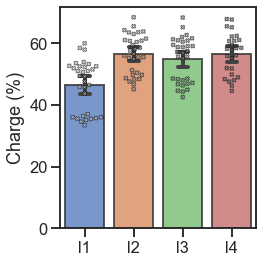

In [4]:
# Plot the Ecoli control:
fig, ax1 = plt.subplots(1, 1, figsize=(4, 4))
mask = (tr_df['tRNA_anno_short'] == 'eColiLys-TTT-1-1')
anno_order = natsorted(set(tr_df['barcode']))

g1 = sns.barplot(ax=ax1, data=tr_df[mask], y='charge', x='barcode', \
                 order=anno_order, capsize=0.2, edgecolor=".2", linewidth=2, alpha=0.8, \
                 zorder=1)
g1 = sns.swarmplot(ax=ax1, data=tr_df[mask], y='charge', x='barcode', \
                   order=anno_order, \
                   palette='light:grey', alpha=0.6, edgecolor='black', linewidth=0.8, \
                   size=4, marker="X", legend=False, \
                   zorder=2)

g1.set(xlabel='', ylabel='Charge (%)')
fig.tight_layout()
fig.savefig('data/plotting/Ecoli-Lys-ctr_BCcomp.pdf', bbox_inches='tight')

In [5]:
# Trim dataframe and select rows with unique annotation:
mask = tr_df['unique_annotation']
tr_df_trim = tr_df.loc[mask, ['sample_name', 'barcode', 'tRNA_anno_short', 'UMIcount', 'charge']].copy()

# Extract the charge for each barcode:
tr_df_trim['charge_l1'] = (tr_df_trim['barcode'] == 'l1') * tr_df_trim['charge']
tr_df_trim['charge_l2'] = (tr_df_trim['barcode'] == 'l2') * tr_df_trim['charge']
tr_df_trim['charge_l3'] = (tr_df_trim['barcode'] == 'l3') * tr_df_trim['charge']
tr_df_trim['charge_l4'] = (tr_df_trim['barcode'] == 'l4') * tr_df_trim['charge']

# Group rows to put replicate samples on the same row:
df_comp = tr_df_trim.groupby(['sample_name', 'tRNA_anno_short']).agg(UMIcount=('UMIcount', 'min'), \
                                                                     charge_l1=('charge_l1', 'max'), \
                                                                     charge_l2=('charge_l2', 'max'), \
                                                                     charge_l3=('charge_l3', 'max'), \
                                                                     charge_l4=('charge_l4', 'max')).reset_index()

# df_comp['sample_name-tRNA_anno_short'] = [snam + '-' + tann for snam, tann in zip(df_comp['sample_name'], df_comp['tRNA_anno_short'])]
#df_comp['N_above'] = ((df_comp['charge_l1'] > 30) * 1) + \
#                     ((df_comp['charge_l2'] > 30) * 1) + \
#                     ((df_comp['charge_l3'] > 30) * 1) + \
#                     ((df_comp['charge_l4'] > 30) * 1)

# Mask minimum count:
mask = (df_comp['UMIcount'] > 1000)

# Mask for different comparisons,
# l1 vs l2 etc.
# Require charge to be above 20% to remove,
# some close to zero outliers:
mask12 = (df_comp['charge_l1'] > 20) & \
         (df_comp['charge_l2'] > 20)

mask23 = (df_comp['charge_l2'] > 20) & \
         (df_comp['charge_l3'] > 20)

mask34 = (df_comp['charge_l3'] > 20) & \
         (df_comp['charge_l4'] > 20)

# Get dataframes for comparison:
df_comp12 = df_comp[mask&mask12].copy().reset_index(drop=True)
df_comp23 = df_comp[mask&mask23].copy().reset_index(drop=True)
df_comp34 = df_comp[mask&mask34].copy().reset_index(drop=True)

# Extract the differences:
df_comp12['l1-l2_diff'] = df_comp12['charge_l1'] - df_comp12['charge_l2']
df_comp23['l2-l3_diff'] = df_comp23['charge_l2'] - df_comp23['charge_l3']
df_comp34['l3-l4_diff'] = df_comp34['charge_l3'] - df_comp34['charge_l4']

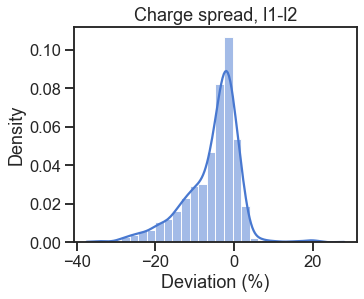

In [6]:
# Plot the charge deviation l1-l2:
fig, ax1 = plt.subplots(1, 1, figsize=(5.4, 4.5))
g1 = sns.histplot(ax=ax1, data=df_comp12, x='l1-l2_diff', \
                  kde=True, bins=30, stat='density')
g1.set(xlabel='Deviation (%)')
g1.set_title('Charge spread, l1-l2')

fig.tight_layout()
fig.savefig('data/plotting/l1-l2-deviation_charge.pdf', bbox_inches='tight')

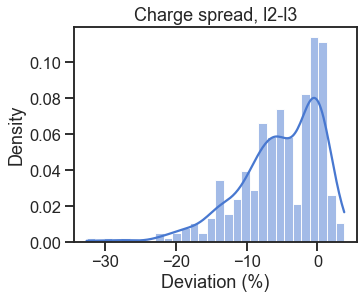

In [7]:
# Plot the charge deviation l2-l3:
fig, ax1 = plt.subplots(1, 1, figsize=(5.4, 4.5))
g1 = sns.histplot(ax=ax1, data=df_comp23, x='l2-l3_diff', \
                  kde=True, bins=30, stat='density')
g1.set(xlabel='Deviation (%)')
g1.set_title('Charge spread, l2-l3')

fig.tight_layout()
fig.savefig('data/plotting/l2-l3-deviation_charge.pdf', bbox_inches='tight')

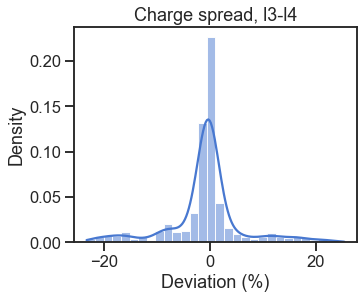

In [8]:
# Plot the charge deviation l3-l4:
fig, ax1 = plt.subplots(1, 1, figsize=(5.4, 4.5))
g1 = sns.histplot(ax=ax1, data=df_comp34, x='l3-l4_diff', \
                  kde=True, bins=30, stat='density')
g1.set(xlabel='Deviation (%)')
g1.set_title('Charge spread, l3-l4')

fig.tight_layout()
fig.savefig('data/plotting/l3-l4-deviation_charge.pdf', bbox_inches='tight')